In [71]:
%config Completer.use_jedi = False  # enable code auto-completion
import warnings

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import csv
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, mean_squared_error  # evaluation metrics
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import multiprocessing
from multiprocessing import Process, Lock, Pipe
from multiprocessing.sharedctypes import Value, Array
from ctypes import Structure, c_double

from copy import deepcopy

print('done')


done


In [72]:
    _TIMEOUT = 100 # seconds

    mdf_raw = tuple([])
    if __name__ == '__main__':
        def get_data(r, ind):
            try:
                fnames = ['merged.csv'] # file downloadable at https://drive.google.com/file/d/1H8LNQs6woDZfWFHv7zMicmi0XyPzRwUD/view?usp=sharing
                # see how merged.csv was formed at the bottom of the notebook
                t = tuple(
                    [pd.read_csv(fname, engine='python', quoting=csv.QUOTE_NONE) for fname in fnames]
                )
                r[ind] = t
            except error as e:
                print(error)

        with multiprocessing.Manager() as manager:

            b1 = manager.list([None])
            p1 = Process(
                target=get_data,
                name='get_data_process',
                args=(b1, 0)
            )
            p1.start()
            p1.join(timeout=_TIMEOUT)
            p1.terminate()

            if p1.exitcode is None:
                raise(TimeoutError(f'Training took more than {_TIMEOUT} seconds'))
            mdf_raw = deepcopy(b1[0])[0]

        print('done')


done


In [73]:
mdf = mdf_raw.copy(deep=True)
#print(mdf)
print('done')

done


In [74]:
if 'home_team_id' in mdf.columns:
    mdf['team_for_is_home'] = ''
    mdf.loc[mdf['home_team_id'] == mdf['team_id_for'], 'team_for_is_home'] = -1
    mdf.loc[mdf['home_team_id'] != mdf['team_id_for'], 'team_for_is_home'] = 1

if 'goals_away' in mdf.columns and 'goals_home' in mdf.columns:
    mdf['goals_against'] = ''
    mdf['goals_against'] = np.where(mdf['team_for_is_home'] == 1,
                                    mdf['goals_away'],
                                    mdf['goals_home'])
    mdf['goals_for'] = ''
    mdf['goals_for'] = np.where(mdf['team_for_is_home'] == -1,
                                    mdf['goals_away'],
                                    mdf['goals_home'])
    mdf.drop(columns=['goals_away', 'goals_home'], inplace=True)
    c = mdf.columns.tolist()
    c_rearranged = c[:7] + c[-2:] + c[7:-2]
    mdf = mdf[c_rearranged]

# To prevent overfitting
mdf.drop(columns=['team_id_for', 'team_id_against', 'player_id', 'home_team_id'], inplace=True)

print('done')

done


In [75]:
mdf['home_rink_side_start'] = np.where(mdf['home_rink_side_start'] == 'left',
                                    -1,
                                    1)
mdf['playerType'] = np.where(mdf['playerType'] == 'Scorer',
                                    1,
                                    0)
mdf.rename(columns={'playerType': 'scored', 'type': 'game_type', 'periodType': 'period_type', 'periodTime': 'period_time'}, inplace=True)
print("done")

done


In [76]:

mdf['x'] = mdf['team_for_is_home'] * mdf['home_rink_side_start'] * ((mdf['period'] % 2) * 2 - 1) * mdf['x']
mdf['y'] = mdf['team_for_is_home'] * mdf['home_rink_side_start'] * ((mdf['period'] % 2) * 2 - 1) * mdf['y']
mdf.drop(columns=['home_rink_side_start'], inplace=True)

print(f'Median horizontal distance from center court on scoring shots (in feet): {mdf[mdf["scored"] == 1]["x"].median()}')
print(f'Median vertical distance from center court on scoring shots (in feet): {mdf[mdf["scored"] == 1]["y"].median()}')


Median horizontal distance from center court on scoring shots (in feet): 73.0
Median vertical distance from center court on scoring shots (in feet): 0.0


In [77]:
for col in mdf.columns:
    print(f'{col}: {mdf[col].isnull().sum()}')

x: 65616
y: 65598
period: 0
period_type: 0
period_time: 0
goals_against: 0
goals_for: 0
scored: 0
game_type: 0
team_for_is_home: 0


In [78]:

cont_features = ['x', 'y', 'period', 'period_time', 'goals_for', 'goals_against']

cat_features = list(filter(lambda col: col not in cont_features + [target_feature], mdf.columns))
target_feature = 'scored'


# Filter the dataframe to only include rows with a value for x and y


for f in cont_features:
    mdf[f] = mdf[f].to_frame().apply(lambda x: x.fillna(str(x.median())), axis=0)
    mdf[f] = pd.to_numeric(mdf[f])

for f in cat_features:
    mdf[f] = mdf[f].to_frame().apply(lambda x: x.fillna(""), axis=0)
    mdf[f] = mdf[f].astype("category").cat.codes

# Standardize
mdf[cont_features + cat_features] = StandardScaler().fit_transform(mdf[cont_features + cat_features])

if mdf.isnull().values.any():
    raise Exception(f"Filling missing values failed")

print('done')

done


In [79]:
print(mdf.head())

          x         y    period  period_type  period_time  goals_against  \
0  0.785728 -0.513512 -1.192651     0.065152    -1.540089      -0.993954   
1  1.077636 -0.285486 -1.192651     0.065152    -1.534384      -0.276035   
2  0.528161 -0.399499 -1.192651     0.065152    -1.497303      -0.993954   
3  0.201911  1.367705 -1.192651     0.065152    -1.314752      -0.276035   
4 -1.652565  0.626619 -1.192651     0.065152    -1.283376      -0.993954   

   goals_for  scored  game_type  team_for_is_home  
0  -0.976019       0   0.290991         -0.984331  
1  -0.976019       1   0.290991         -0.984331  
2  -0.255148       0   0.290991          1.015918  
3  -0.976019       0   0.290991         -0.984331  
4  -0.255148       0   0.290991          1.015918  


In [80]:
# splits data randomly according to a 70/20/10 split
def split_data(data: pd.DataFrame, training_data_percentage=0.70,
               val_data_percentage=0.2, 
               max_rows=700000):
    rows = min(data.shape[0], max_rows)
    training_data, val_data, test_data = tuple(
        pd.DataFrame(arr)
        for arr in np.split(  # Halves array
            data.sample(n=rows, random_state=42),
            [int(rows * (training_data_percentage)),
             int(rows * (training_data_percentage + val_data_percentage))],
        )
    )
    return training_data, val_data, test_data

training_data, val_data, test_data = split_data(mdf)

print('Row counts:')
for p in [('train', training_data), ('val', val_data), ('test', test_data)]:
    print(f'\t{p[0]}:\t{p[1].shape[0]}')


Row counts:
	train:	489999
	val:	140000
	test:	70001


In [81]:
scaler = StandardScaler()

x_train = training_data.drop([target_feature], axis=1)
x_val = val_data.drop([target_feature], axis=1)
x_test = test_data.drop([target_feature], axis=1)

x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.fit_transform(x_test)

y_train = training_data[target_feature]
y_val = val_data[target_feature]
y_test = test_data[target_feature]

print('done')

done


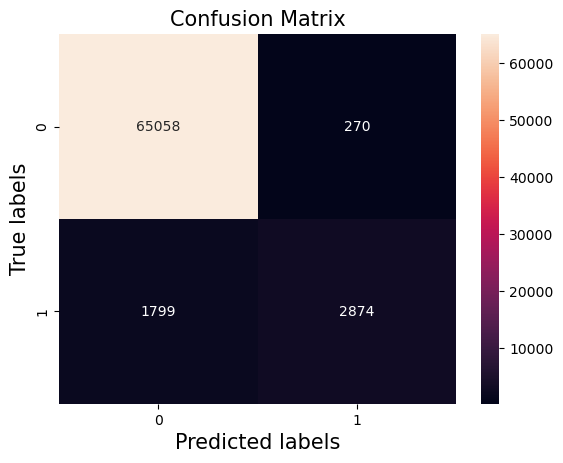

F1: 0.7353204554176794
Precision: 0.9141221374045801
Accuracy: 0.9704432793817231
Trained using the following features:
	x
	y
	period
	period_type
	period_time
	goals_against
	goals_for
	scored
	game_type
	team_for_is_home


In [82]:

# Support for model choice below this cell
mdl = RandomForestClassifier(criterion='log_loss', max_depth=30)
mdl.fit(x_train, y_train)
preds_nd_array = mdl.predict(x_test)
pred = torch.tensor([[num] for num in preds_nd_array])
targ = torch.tensor([[num] for num in list(y_test)])

def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)


generate_confusion_matrix(targ, pred)
plt.show()

f1 = f1_score(targ, pred)
prec = precision_score(targ, pred)
acc = accuracy_score(targ, pred)

print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Accuracy: {acc}')
print(f'Trained using the following features:\n\t{(chr(10) + chr(9)).join(mdf.columns)}')

In [ ]:
# Train and get predictions

raise Exception("the following cells are for optimization purposes and take a long time to run, comment out this exception if you really want to see them do their thing")

f1s = []
val_errors = []
depths = [3, 5, 10, 20, 30, 50]
for depth in depths:
    mdl = RandomForestClassifier(criterion='log_loss', max_depth=depth)
    mdl.fit(x_train, y_train)
    preds_nd_array = mdl.predict(x_val)
    pred = torch.tensor([[num] for num in preds_nd_array])
    targ = torch.tensor([[num] for num in list(y_val)])
    f1 = f1_score(targ, pred)
    mse = mean_squared_error(targ, pred)
    f1s.append(f1)
    val_errors.append(mse)
    print(f1)

print('done')

In [ ]:
print(val_errors[4])

In [ ]:
# plot results
fig, ax = plt.subplots()
ax.set_xlabel("max_depth")
ax.set_yticks([0,1])
ax.set_ylabel('Validation error')
ax.set_title("Random forest classifier")
ax.plot(depths, val_errors)
ax.set_axis_on()
ax.legend()
plt.show()

In [ ]:
# Train and get predictions

f1s = []
val_errors = []
num_layers = [1,2,4,6,8]
for size in num_layers:
    size_array = tuple([15]*size)
    mdl = MLPClassifier(hidden_layer_sizes=size_array)
    mdl.fit(x_train, y_train)
    preds_nd_array = mdl.predict(x_val)
    pred = torch.tensor([[num] for num in preds_nd_array])
    targ = torch.tensor([[num] for num in list(y_val)])
    f1 = f1_score(targ, pred)
    mse = mean_squared_error(targ, pred)
    f1s.append(f1)
    val_errors.append(mse)
    print(mse, f1)

print('done')
        

In [ ]:
# plot results
fig, ax = plt.subplots()
ax.set_xlabel("num_layers")
ax.set_yticks([0,1])
ax.set_ylabel('Validation error')
ax.set_title("MLPClassifier")
ax.plot(num_layers, val_errors)
ax.set_axis_on()
ax.legend()
plt.show()

In [ ]:
# NOTE this snippet of code was run locally because of kernel timeout issues on the jupyter server

raise Exception("This snippet of code can not be run on jupyter server due to kernel timeout issues and needs three files (see below) downloaded")

import pandas as pd
import numpy as np

def get_data():
    fnames = ('game_plays.csv', 'game_plays_players.csv', 'game.csv')
    # Files downloadable at https://www.kaggle.com/datasets/martinellis/nhl-game-data
    gp, gpp, g = tuple(
        [pd.read_csv(fname) for fname in fnames]
    )
    gp.drop(columns=['st_x', 'st_y', 'dateTime', 'secondaryType', 'description', 'periodTimeRemaining'], inplace=True)
    game_plays_players_filtered = gpp[
        gpp['playerType'].isin(['Shooter', 'Scorer'])
    ]
    game_plays_filtered.drop(columns=['event'])
    game_plays_players_filtered.drop(columns=['game_id'], inplace=True)

    g = g[['game_id', 'type', 'home_rink_side_start', 'home_team_id']]

    # mdf = merged dataframe
    mdf = pd.merge(game_plays_players_filtered, game_plays_filtered, on='play_id', how='left')
    mdf = pd.merge(mdf, g, on='game_id', how='left')
    mdf.drop(columns=['game_id', 'event', 'play_id'], inplace=True)
    mdf.to_csv('merged.csv', index=False)

get_data()
